In [1]:
# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

In [3]:
authors = pd.read_csv("/Users/zhechensu/Downloads/nips_dataset/authors.csv")
paper_authors = pd.read_csv("/Users/zhechensu/Downloads/nips_dataset/paper_authors.csv")
papers = pd.read_csv("/Users/zhechensu/Downloads/nips_dataset/papers.csv")

In [4]:
papers.head(10)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."
5,1002,1994,Using a neural net to instantiate a deformable...,NaN,1002-using-a-neural-net-to-instantiate-a-defor...,Abstract Missing,U sing a neural net to instantiate a\ndeformab...
6,1003,1994,Plasticity-Mediated Competitive Learning,NaN,1003-plasticity-mediated-competitive-learning.pdf,Abstract Missing,Plasticity-Mediated Competitive Learning\n\nTe...
7,1004,1994,ICEG Morphology Classification using an Analog...,NaN,1004-iceg-morphology-classification-using-an-a...,Abstract Missing,ICEG Morphology Classification using an\nAnalo...
8,1005,1994,Real-Time Control of a Tokamak Plasma Using Ne...,NaN,1005-real-time-control-of-a-tokamak-plasma-usi...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...
9,1006,1994,Pulsestream Synapses with Non-Volatile Analogu...,NaN,1006-pulsestream-synapses-with-non-volatile-an...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...


In [5]:
paper_authors.head(10)

,id,paper_id,author_id
0,1,63,94
1,2,80,124
2,3,80,125
3,4,80,126
4,5,80,127
5,6,9,13
6,7,20,33
7,8,20,34
8,9,20,35
9,10,66,99


In [6]:
authors.head(10)

,id,name
0,1,Hisashi Suzuki
1,10,David Brady
2,100,Santosh S. Venkatesh
3,1000,Charles Fefferman
4,10000,Artur Speiser
5,10001,Fabio Cecchi
6,10002,Nidhi Hegde
7,10003,Ethan Elenberg
8,10004,Moran Feldman
9,10005,Will Dabney


# Coauthorship network (1st method)

In [43]:
df_all = pd.merge(papers, paper_authors, left_on='id', right_on='paper_id')
df_all = pd.merge(df_all, authors, left_on='author_id', right_on='id')
df_all = df_all[df_all['year']>2015]
df = df_all[['paper_id', 'author_id', 'name']]
df.head(10)

,paper_id,author_id,name
45,7417,54,Terrence J. Sejnowski
132,6057,121,Geoffrey E. Hinton
133,6230,121,Geoffrey E. Hinton
134,6975,121,Geoffrey E. Hinton
138,8148,121,Geoffrey E. Hinton
218,6262,969,Thomas Hofmann
219,6797,969,Thomas Hofmann
221,7780,969,Thomas Hofmann
222,7854,969,Thomas Hofmann
306,6241,1020,Zoubin Ghahramani


## Create graph

In [26]:
# Initialize graph
G = nx.Graph()

# Transform
# REMARK: The algorithm seems more stable by doing '*=2' than '+=1'
# REMARK: I use 'name' instead of 'author_id' for label purposes.
for p, a in df.groupby('paper_id')['name']: 
    for u, v in itertools.combinations(a, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] *= 2
        else:
            G.add_edge(u, v, weight=1)
            
# Print graph size
print('\nSize of graph, i.e. number of edges:', G.size())


Size of graph, i.e. number of edges: 12602


## Compute best partition

In [27]:
# Get best partition
partition = community.best_partition(G)
print('Modularity: ', community.modularity(partition, G))

Modularity:  0.937617346343217


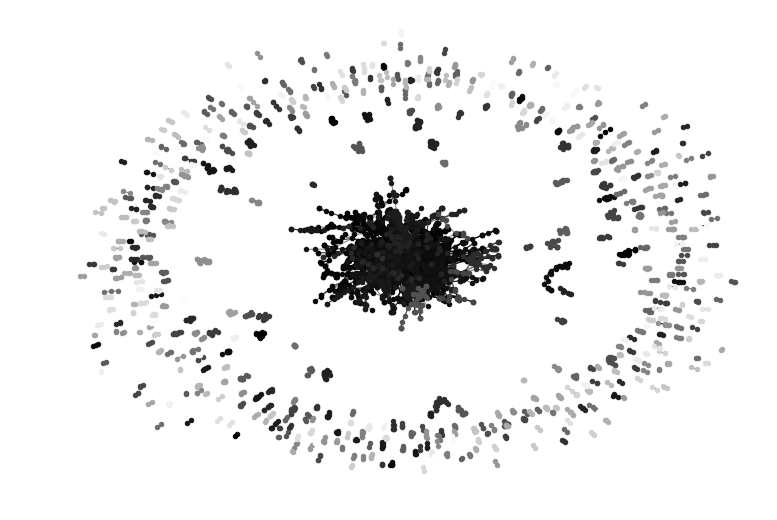

In [28]:
plt.figure(figsize=(13, 9))
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20, node_color = str(count / size))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis('off')
plt.show()

## Filter communities
Let's have a look at the largest communities detected. The ones with more than 120 members.

In [37]:
# Keep only communities with a minimum of authors
centers = {}
communities = {}
G_main_com = G.copy()
min_nb = 120
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    if len(list_nodes) < min_nb:
        G_main_com.remove_nodes_from(list_nodes)
    else:
        # Get center
        H = G_main_com.subgraph(list_nodes)
        d_c = nx.degree_centrality(H)
        center = max(d_c, key=d_c.get)
        centers[center] = com
        communities[com] = center
        # Print community
        print('Community of ', center , '(ID ', com, ') - ', len(list_nodes), ' authors:')
        print(list_nodes, '\n')

Community of  Francis Bach (ID  4 ) -  131  authors:
['John C. Duchi', 'Hongseok Namkoong', 'Anatoli Juditsky', 'Arkadi S. Nemirovski', 'Zaid Harchaoui', 'Dmitry Ostrovsky', 'Prateek Jain', 'Nagarajan Natarajan', 'Aman Sinha', 'Percy S. Liang', 'Jacob Steinhardt', 'Sham M. Kakade', 'Praneeth Netrapalli', 'Marco Cuturi', 'Grégoire Montavon', 'Francis Bach', "Alexandre d'Aspremont", 'Damien Scieur', 'Jalal Fadili', 'Jingwei Liang', 'Gabriel Peyré', 'Ashutosh Saxena', 'Hyun Oh Song', 'Ozan Sener', 'Silvio Savarese', 'Tatiana Shpakova', 'John Lafferty', 'Rina Foygel Barber', 'Gregory Valiant', 'Moses Charikar', 'Balamurugan Palaniappan', 'Christopher B. Choy', 'JunYoung Gwak', 'Manmohan Chandraker', 'Edouard Pauwels', 'Jean B. Lasserre', 'Kévin Degraux', 'Laurent Jacques', 'Aude Genevay', 'Simon Lacoste-Julien', 'Pascal Germain', 'Alexandre Lacoste', 'Yuancheng Zhu', 'sabyasachi chatterjee', 'Fabian Pedregosa', 'Rémi Leblond', 'Anton Osokin', 'Guobin Chen', 'Wongun Choi', 'Xiang Yu', 'Tony

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

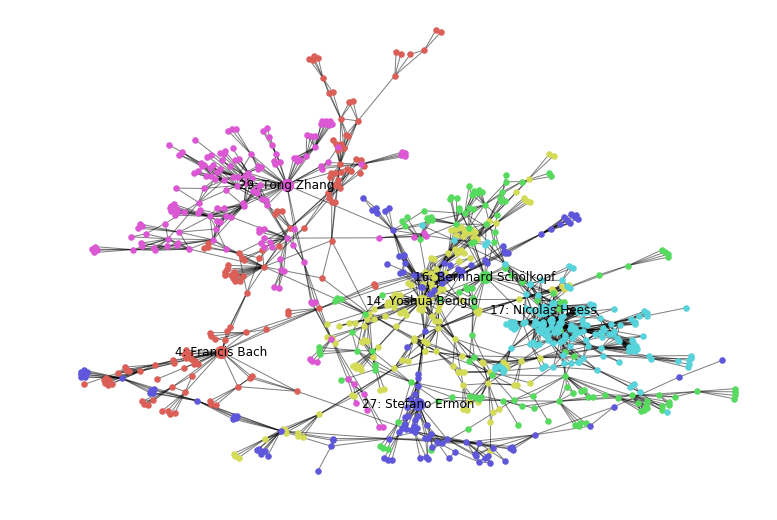

In [38]:
# Display graph
plt.figure(figsize=(13, 9))
node_size = 30
count = 0
pos = nx.spring_layout(G_main_com)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(G_main_com, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_main_com, pos, list([communities[com]]), node_size = node_size*5, node_color = colors[com])
nx.draw_networkx_edges(G_main_com, pos, alpha=0.5)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
nx.draw_networkx_labels(G_main_com, pos, labels)
plt.axis('off')
plt.show()

In [39]:
# Display induced graph
nodes_main_com = {k: v for k, v in partition.items() if v in communities}
ind = community.induced_graph(nodes_main_com, G_main_com)
print('Number of communities', len(ind.nodes()))
print('\nMain communities and their center node:', communities)

Number of communities 6

Main communities and their center node: {4: 'Francis Bach', 14: 'Yoshua Bengio', 16: 'Bernhard Schölkopf', 17: 'Nicolas Heess', 27: 'Stefano Ermon', 29: 'Tong Zhang'}


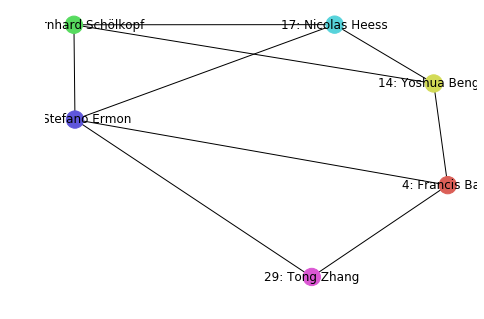

In [40]:
# Display induced graph
pos_ind = nx.spring_layout(ind)
labels = {k: str(k) + ': ' + v for k,v in communities.items()}
nx.draw(ind, pos_ind, node_list=list(colors.keys()), node_color=list(colors.values()), labels=labels)
plt.show()

# Coauthorship network (2nd method)

In [45]:
df_all.head(5)

,id_x,year,title,event_type,pdf_name,abstract,paper_text,id_y,paper_id,author_id,id,name
45,7417,2018,Gradient Descent for Spiking Neural Networks,Poster,7417-gradient-descent-for-spiking-neural-netwo...,Most large-scale network models use neurons wi...,Gradient Descent for Spiking Neural Networks\n...,21347,7417,54,54,Terrence J. Sejnowski
132,6057,2016,Using Fast Weights to Attend to the Recent Past,Poster,6057-using-fast-weights-to-attend-to-the-recen...,"Until recently, research on artificial neural ...",Using Fast Weights to Attend to the Recent Pas...,18023,6057,121,121,Geoffrey E. Hinton
133,6230,2016,"Attend, Infer, Repeat: Fast Scene Understandin...",Poster,6230-attend-infer-repeat-fast-scene-understand...,We present a framework for efficient inference...,"Attend, Infer, Repeat:\nFast Scene Understandi...",17599,6230,121,121,Geoffrey E. Hinton
134,6975,2017,Dynamic Routing Between Capsules,Poster,6975-dynamic-routing-between-capsules.pdf,A capsule is a group of neurons whose activity...,Dynamic Routing Between Capsules\n\nSara Sabou...,19653,6975,121,121,Geoffrey E. Hinton
138,8148,2018,Assessing the Scalability of Biologically-Moti...,Poster,8148-assessing-the-scalability-of-biologically...,The backpropagation of error algorithm (BP) is...,Assessing the Scalability of Biologically-Moti...,24097,8148,121,121,Geoffrey E. Hinton


In [46]:
authors.head()

,id,name
0,1,Hisashi Suzuki
1,10,David Brady
2,100,Santosh S. Venkatesh
3,1000,Charles Fefferman
4,10000,Artur Speiser


In [64]:
self_merge = pd.merge(df_all, df_all, on='paper_id')
self_merge = self_merge[self_merge.name_x != self_merge.name_y]
nodes = df_all[~df_all.name.duplicated()].reset_index(drop=True).reset_index()
name_index = nodes.name.to_dict()
name_index = {v: k for k, v in name_index.items()}
self_merge['source'] = self_merge.name_x.map(name_index)
self_merge['target'] = self_merge.name_y.map(name_index)

In [65]:
import numpy as np
def get_adjacency(nodes, edges):
    n_nodes = len(nodes)
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

    for idx, row in edges.iterrows():
        i, j = int(row.source), int(row.target)
        adjacency[i, j] += 1

    return adjacency

adjacency = get_adjacency(nodes, self_merge)
graph = nx.from_numpy_array(adjacency)

In [70]:
edge_dict = {}
keyword_dict = {}
for i, row in self_merge.iterrows():
    edge_dict[(row['source'], row['target'])] =  row['year_x']
    keyword_dict[(row['source'], row['target'])] =  row['event_type_x']

In [73]:
nx.set_edge_attributes(graph, edge_dict, name='year')
nx.set_edge_attributes(graph, keyword_dict, name='event_type')
mapping = nodes.name.to_dict()

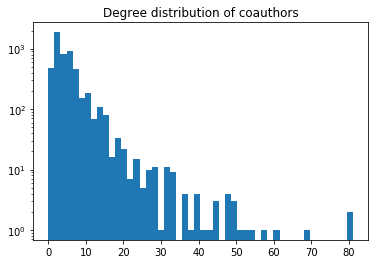

In [74]:
plt.title('Degree distribution of coauthors')
plt.hist(adjacency.sum(axis=1), bins=50, log=True)
plt.show()

This is a simple drawing of our network: we see that there is a large core communit, and many many smaller comminitues of co authors. We will look more into the main community

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


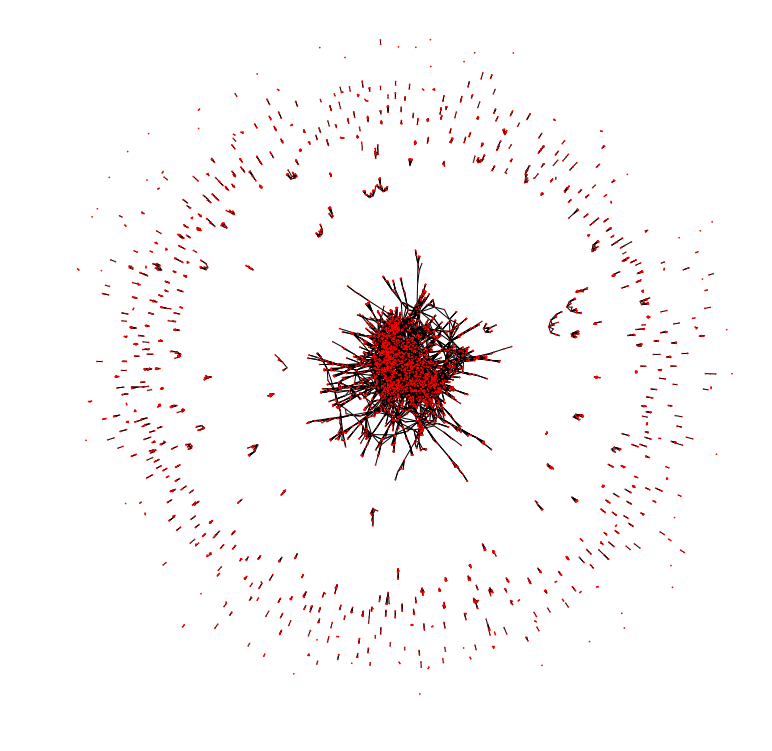

In [75]:
pos = nx.layout.fruchterman_reingold_layout(graph)
plt.figure(figsize=(10, 10))
nx.draw(graph, pos=pos, node_size=[0.5,0.5])

In [81]:
largest_cc = max(nx.connected_components(graph), key=len)
print(f'the largest component contains : {len(largest_cc)} people')

the largest component contains : 2966 people


In [83]:
nx.average_shortest_path_length(graph.subgraph(largest_cc))

7.16955103312528

In [84]:
nx.average_clustering(graph.subgraph(largest_cc))

0.7816023627994058

In [85]:
nx.density(graph.subgraph(largest_cc))

0.001979488730627835

**Same graph for people who collaborated at least on 3 papers:**

e.g. we look at frequent collaborators (also forming a main component)

In [92]:
G = nx.Graph(((source, target, attr) for source, target, attr in graph.edges(data=True) if attr['weight'] > 1))
# nx.set_node_attributes(G, nodes.country.to_dict(), name='country')
# nx.set_node_attributes(G, nodes.name.to_dict(), name='uni')
nx.set_node_attributes(G, nodes.name.to_dict(), name='author')

largest_ccs = [i for i in nx.connected_components(G) if len(i) > 9 and len(i) < 50]
len(largest_ccs)

10

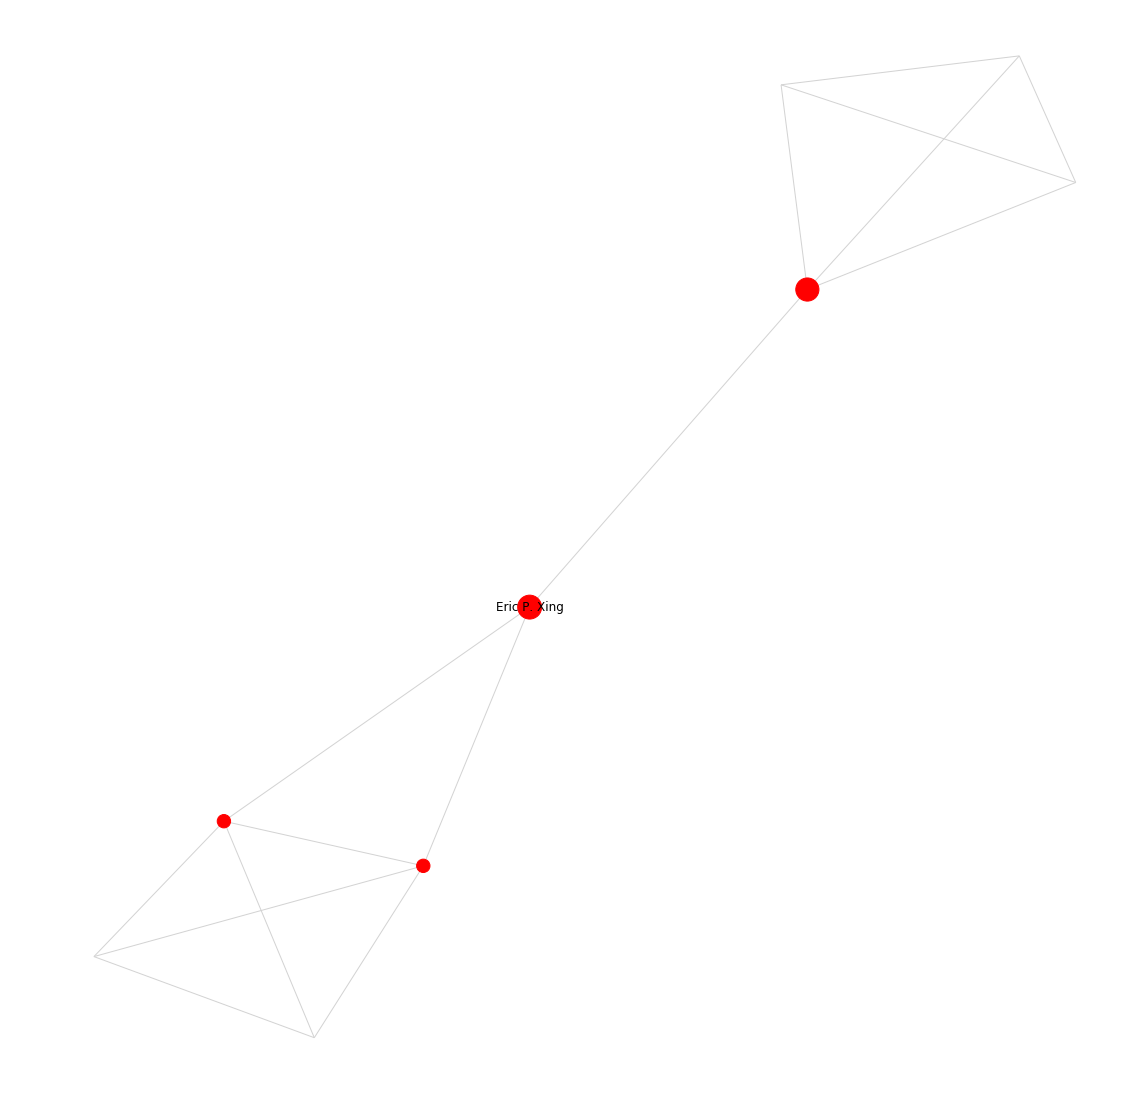

In [96]:
lc = max(nx.connected_components(G), key=len)
core = nx.k_core(G.subgraph(lc), k=3)
core = core.subgraph(max(nx.connected_components(core), key=len))
node_size = pd.Series(nx.betweenness_centrality(core))
labels = nx.get_node_attributes(core.subgraph(node_size[node_size.quantile(0.95) < node_size].index), 'author')
plt.figure(figsize=(15, 15))
pos= nx.layout.spring_layout(core)
nx.draw(core,pos=pos, edge_color='lightgray', node_size=node_size*1000, span=0.01, labels=labels, seed=2)
plt.savefig('figure/author_collab_large.pdf')